In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
from scipy.optimize import minimize, basinhopping
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn import linear_model
import pyfolio as pf
import empyrical
%matplotlib inline

In [53]:
DATA_DIR = 'D:\workspace\zjsxzy_in_js\Research\data'

In [54]:
fname = '%s/assets.xlsx'%(DATA_DIR)

In [55]:
odf = pd.read_excel(fname, index_col=0)

In [56]:
odf.tail()

,881001.WI,HSI.HI,SPX.GI,065.CS,AU9999.SGE,B.IPE,H11025.CSI
2017-10-31,4672.8540,28245.54,2575.26,173.5462,273.94,61.18,1445.6749
2017-11-01,4668.3505,28594.06,2579.36,173.7010,273.45,60.44,1445.8329
2017-11-02,4642.4485,28518.64,2579.85,173.6781,273.34,60.70,1445.9918
2017-11-03,4620.7182,28603.61,2587.84,173.6782,273.60,62.09,1446.1513
2017-11-06,4661.1561,28596.80,2591.13,173.7269,273.00,64.11,1446.1513


In [57]:
def metric(daily_ret):
    an_ret = empyrical.annual_return(daily_ret)
    sharpe = empyrical.sharpe_ratio(daily_ret)
    vol = empyrical.annual_volatility(daily_ret)
    maxdraw = empyrical.max_drawdown(daily_ret)
    print 'Annual return: %.2f%%'%(an_ret*100)
    print 'Sharpe ratio: %.2f'%(sharpe)
    print 'Annual volatility: %.2f%%'%(vol*100)
    print 'Max drawdown: %.2f%%'%(maxdraw*100)

In [139]:
df = odf[['881001.WI', 'HSI.HI', '065.CS']]

In [140]:
ret_df = df.pct_change().dropna()

# 得到波动率与最大回撤的关系

In [91]:
dic = {}
K = 20
for col in ret_df.columns:
    dic[col] = pd.DataFrame({'vol': ret_df[col].rolling(window=K).apply(lambda x: x.std()),
                             'mdd': ret_df[col].rolling(window=K).apply(lambda x: empyrical.max_drawdown(x))})
pnl = pd.Panel(dic)

In [141]:
months = pd.Series([(x.year, x.month) for x in ret_df.index], index=ret_df.index)
rebalance_dates = months.drop_duplicates(keep='last').index

In [148]:
weight = pd.DataFrame(columns=ret_df.columns, index=ret_df.index)
# drawdown_df = pd.DataFrame(columns=ret_df.columns, index=rebalance_dates)
wb = np.zeros(ret_df.shape[1])
for date in ret_df.index:
    weight.loc[date] = wb
    if date in rebalance_dates:
        K = 20
        past_return = ret_df[ret_df.index <= date][-K:]
        if past_return.shape[0] == K:
            max_drawdown = pd.Series(index=past_return.columns)
            sharpe = pd.Series(index=past_return.columns)
            for col in past_return.columns:
                vol = past_return[col].std()
                vol_mdd = pnl[col]
                vol_mdd = vol_mdd[vol_mdd.index <= date]
                std = vol_mdd['vol'].std()
                mdd = vol_mdd[(vol_mdd['vol'] >= vol-0.5*std) & (vol_mdd['vol'] <= vol+0.5*std)]['mdd'].mean()
#                 mdd = empyrical.max_drawdown(past_return[col])
#                 mdd = past_return[col].rolling(window=20).apply(lambda x: empyrical.max_drawdown(x)).max()
#                 dvol = empyrical.annual_volatility(past_return[col])
                max_drawdown.loc[col] = mdd
#                 sharpe[col] = empyrical.sharpe_ratio(past_return[col])
#                 drawdown_df.loc[date, col] = mdd
#             wb = -(sharpe ** 2) / max_drawdown
            wb = -1. / max_drawdown
            wb /= wb.sum()

In [149]:
weight.drop_duplicates()

,881001.WI,HSI.HI,065.CS
2007-01-05,0,0,0
2007-03-01,0.0129036,0.029325,0.957771
2007-04-02,0.0647503,0.0171937,0.918056
2007-05-08,0.0269024,0.0470642,0.926033
2007-06-01,0.0487652,0.135672,0.815562
2007-07-02,0.0211388,0.132038,0.846823
2007-08-01,0.028862,0.0927502,0.878388
2007-09-03,0.0329,0.0102226,0.956877
2007-10-08,0.114028,0.124455,0.761517
2007-11-01,0.0467107,0.0415823,0.911707


In [150]:
portfolio_ret = (weight * ret_df).sum(axis=1)

In [151]:
portfolio_ret = portfolio_ret[portfolio_ret != 0]

In [152]:
metric(portfolio_ret)

Annual return: 5.08%
Sharpe ratio: 2.16
Annual volatility: 2.30%
Max drawdown: -3.44%


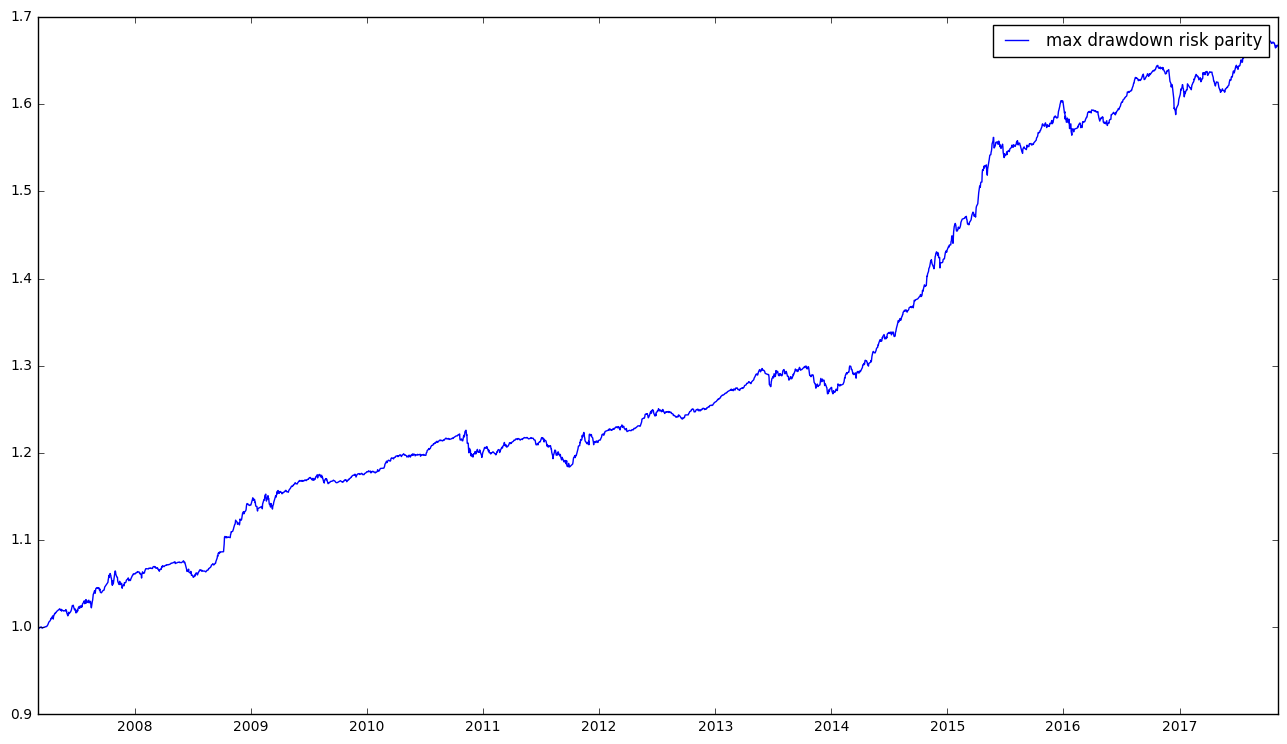

In [153]:
plt.figure(figsize=(16, 9))
plt.plot((1+portfolio_ret).cumprod(), label='max drawdown risk parity')
plt.legend()

# 真实最大回撤

In [93]:
weight = pd.DataFrame(columns=ret_df.columns, index=ret_df.index)
wb = np.zeros(ret_df.shape[1])
for date in ret_df.index:
    weight.loc[date] = wb
    if date in rebalance_dates:
        past_return = ret_df[ret_df.index >= date][:20]
        if past_return.shape[0] == 20:
            max_drawdown = pd.Series(index=past_return.columns)
            for col in past_return.columns:
                mdd = pf.empyrical.max_drawdown(past_return[col])
                max_drawdown.loc[col] = mdd
            wb = -1. / max_drawdown
            wb /= wb.sum()

In [94]:
portfolio_ret2 = (weight * ret_df).sum(axis=1)

In [95]:
portfolio_ret2 = portfolio_ret2[portfolio_ret2 != 0]

In [96]:
metric(portfolio_ret2)

Annual return: 12.45%
Sharpe ratio: 3.89
Annual volatility: 3.03%
Max drawdown: -2.96%


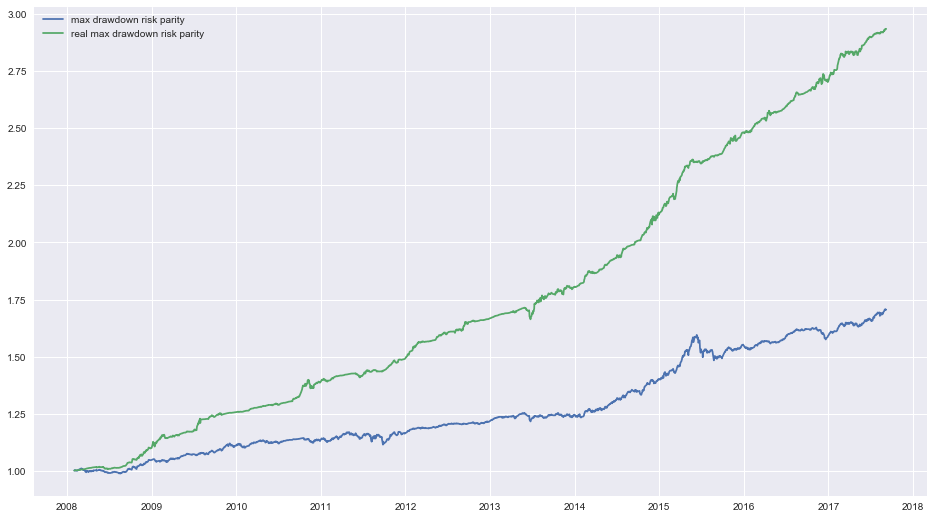

In [97]:
plt.figure(figsize=(16, 9))
plt.plot((1+portfolio_ret).cumprod(), label='max drawdown risk parity')
portfolio_ret2 = portfolio_ret2[portfolio_ret2.index >= portfolio_ret.index[0]]
plt.plot((1+portfolio_ret2).cumprod(), label='real max drawdown risk parity')
plt.legend()

# 波动率与最大回撤的关系

In [25]:
ret_df.head()

,881001.WI,HSI.HI,SPX.GI,065.CS,AU9999.SGE
2007-01-05,0.009009,0.009273,-0.006085,0.000318,-0.010342
2007-01-08,0.032302,-0.008986,0.002220,0.000030,-0.020517
2007-01-09,0.028045,-0.006569,-0.000517,0.000300,0.004749
2007-01-10,0.025026,-0.016571,0.001940,0.000303,-0.000712
2007-01-11,-0.005483,-0.009350,0.006340,0.000298,-0.003110


In [26]:
close = ret_df['881001.WI']

In [27]:
K = 60
vol = close.rolling(window=K).apply(lambda x: pf.empyrical.annual_volatility(x))
mdd = close.rolling(window=K).apply(lambda x: pf.empyrical.max_drawdown(x))
ret = close.rolling(window=K).apply(lambda x: pf.empyrical.cum_returns_final(x))

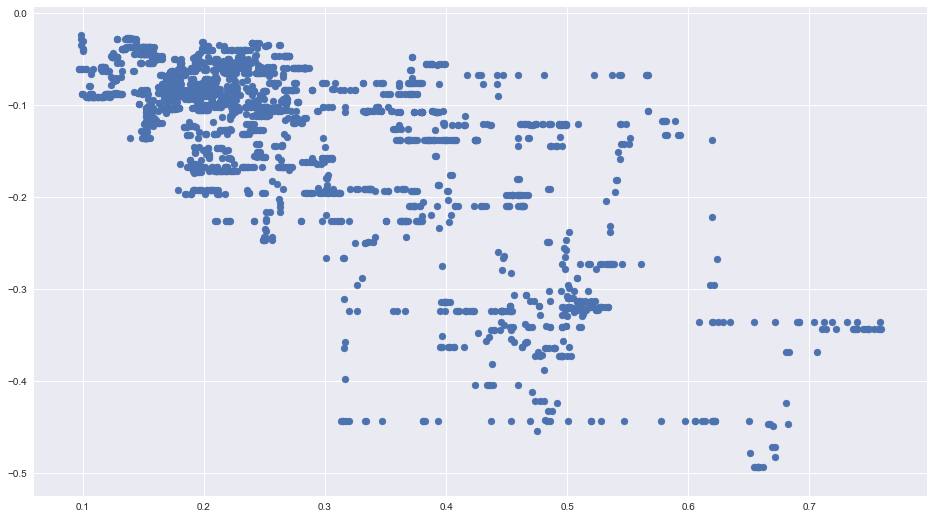

In [28]:
plt.figure(figsize=(16, 9))
plt.scatter(vol[:-K], mdd.shift(-20)[:-K])

# 最大回撤与波动率、收益率模型

In [29]:
ret_df.head()

,881001.WI,HSI.HI,SPX.GI,065.CS,AU9999.SGE
2007-01-05,0.009009,0.009273,-0.006085,0.000318,-0.010342
2007-01-08,0.032302,-0.008986,0.002220,0.000030,-0.020517
2007-01-09,0.028045,-0.006569,-0.000517,0.000300,0.004749
2007-01-10,0.025026,-0.016571,0.001940,0.000303,-0.000712
2007-01-11,-0.005483,-0.009350,0.006340,0.000298,-0.003110


In [80]:
param = {}
for col in ret_df.columns:
    series = ret_df[col]
    K = 242
    vol = series.rolling(window=K).apply(lambda x: pf.empyrical.annual_volatility(x))
    mdd = series.rolling(window=K).apply(lambda x: pf.empyrical.max_drawdown(x))
    ret = series.rolling(window=K).apply(lambda x: pf.empyrical.cum_returns_final(x))
    df = pd.DataFrame({'vol': vol, 'ret': ret, 'mdd': mdd})
    df = df.dropna()
    lr = linear_model.LinearRegression(fit_intercept=False)
    X, y = df[['vol', 'ret']], df['mdd']
    lr.fit(X, y)
    param[col] = lr
    print col, '\tR^2 =', lr.score(X, y), lr.coef_

881001.WI 	R^2 = 0.877330600543 [-1.0612803   0.13266532]
HSI.HI 	R^2 = 0.948222161489 [-0.99117612  0.21147377]
SPX.GI 	R^2 = 0.96497640123 [-0.91116166  0.21751206]
065.CS 	R^2 = 0.843583134838 [-2.23567813  0.27185508]
AU9999.SGE 	R^2 = 0.815012316129 [-1.03944706  0.25062859]


In [81]:
param

{u'065.CS': LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False),
 u'881001.WI': LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False),
 u'AU9999.SGE': LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False),
 u'HSI.HI': LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False),
 u'SPX.GI': LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)}

# 预期最大回撤风险平价

In [82]:
weight = pd.DataFrame(columns=ret_df.columns, index=ret_df.index)
wb = np.zeros(ret_df.shape[1])
for date in ret_df.index:
    weight.loc[date] = wb
    if date in rebalance_dates:
        K = 242
        past_return = ret_df[ret_df.index <= date][-K:]
        if past_return.shape[0] == K:
            max_drawdown = pd.Series(index=past_return.columns)
            for col in past_return.columns:
                vol = pf.empyrical.annual_volatility(past_return[col])
                mdd = pf.empyrical.max_drawdown(past_return[col])
                ret = pf.empyrical.cum_returns_final(past_return[col])
                x = np.array([vol, ret])
                pred_mdd = param[col].predict(x.reshape(1, -1))
                if pred_mdd < 0:
                    max_drawdown.loc[col] = pred_mdd
                else:
                    max_drawdown.loc[col] = mdd
            wb = -1. / max_drawdown
            wb /= wb.sum()

In [83]:
# weight.drop_duplicates()[weight.drop_duplicates() < 0].dropna()
# weight.drop_duplicates()

In [84]:
portfolio_ret3 = (weight * ret_df).sum(axis=1)

In [85]:
portfolio_ret3 = portfolio_ret3[portfolio_ret3 != 0]

In [86]:
metric(portfolio_ret3)

Annual return: 5.18%
Sharpe ratio: 1.09
Annual volatility: 4.73%
Max drawdown: -15.67%


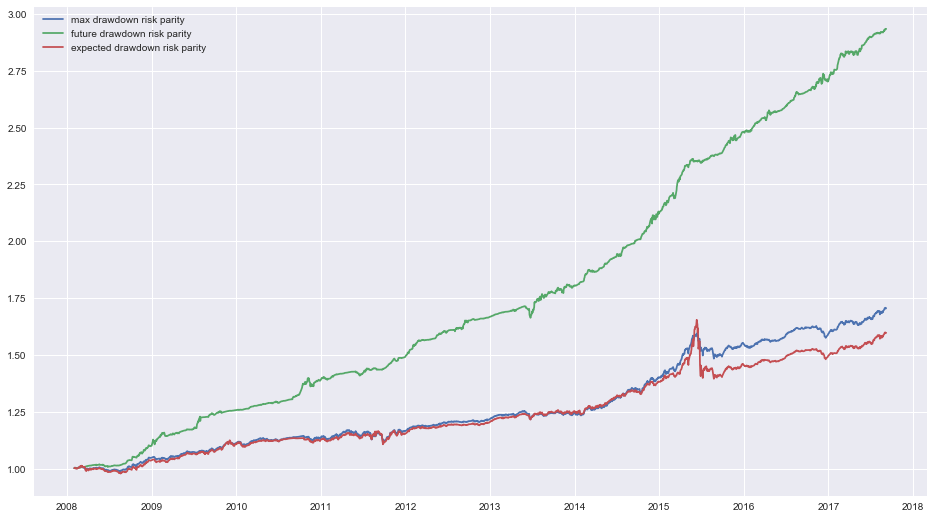

In [98]:
plt.figure(figsize=(16, 9))
plt.plot((1+portfolio_ret).cumprod(), label='max drawdown risk parity')
portfolio_ret3 = portfolio_ret3[portfolio_ret3.index >= portfolio_ret.index[0]]
plt.plot((1+portfolio_ret2).cumprod(), label='future drawdown risk parity')
plt.plot((1+portfolio_ret3).cumprod(), label='expected drawdown risk parity')
plt.legend()

In [99]:
# df = pd.DataFrame({'hist': (1+portfolio_ret).cumprod(),
#                    'pred': (1+portfolio_ret3).cumprod(),
#                    'future': (1+portfolio_ret2).cumprod()})

In [100]:
# df.to_csv('C:/Users/jgtzsx01/Desktop/rp.csv')

# 预期回撤夏普风险预算

In [116]:
weight = pd.DataFrame(columns=ret_df.columns, index=ret_df.index)
wb = np.zeros(ret_df.shape[1])
for date in ret_df.index:
    weight.loc[date] = wb
    if date in rebalance_dates:
        K = 242
        past_return = ret_df[ret_df.index <= date][-K:]
        if past_return.shape[0] == K:
            max_drawdown = pd.Series(index=past_return.columns)
            sharpe = pd.Series(index=past_return.columns)
            for col in past_return.columns:
                vol = pf.empyrical.annual_volatility(past_return[col])
                mdd = pf.empyrical.max_drawdown(past_return[col])
                ret = pf.empyrical.cum_returns_final(past_return[col])
                sharpe[col] = pf.empyrical.sharpe_ratio(past_return[col])
                x = np.array([vol, ret])
                pred_mdd = param[col].predict(x.reshape(1, -1))
                if pred_mdd < 0:
                    max_drawdown.loc[col] = pred_mdd
                else:
                    max_drawdown.loc[col] = mdd if mdd < 0 else -0.00001
            sharpe[sharpe < 0] = 0
            prev_wb = wb
            wb = -sharpe / max_drawdown
            if wb.sum() != 0:
                wb /= wb.sum()
                if wb[3] < 0.3:
                    wb[3] = wb.sum()
                    wb /= wb.sum()
            else:
                wb = prev_wb

In [117]:
# weight.drop_duplicates()

In [118]:
portfolio_ret4 = (weight * ret_df).sum(axis=1)

In [119]:
portfolio_ret4 = portfolio_ret4[portfolio_ret4 != 0]

In [120]:
metric(portfolio_ret4)

Annual return: 4.98%
Sharpe ratio: 0.95
Annual volatility: 5.26%
Max drawdown: -17.43%


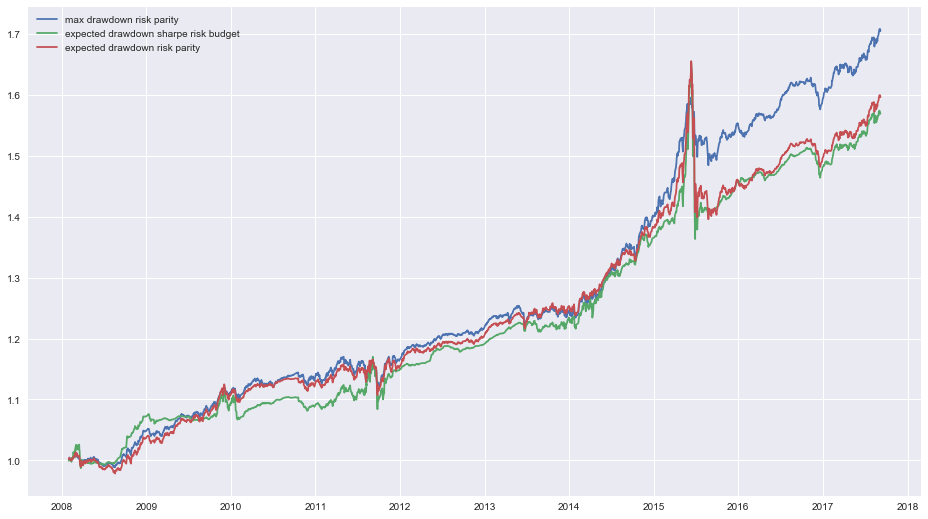

In [121]:
plt.figure(figsize=(16, 9))
plt.plot((1+portfolio_ret).cumprod(), label='max drawdown risk parity')
portfolio_ret4 = portfolio_ret4[portfolio_ret4.index >= portfolio_ret.index[0]]
plt.plot((1+portfolio_ret4).cumprod(), label='expected drawdown sharpe risk budget')
plt.plot((1+portfolio_ret3).cumprod(), label='expected drawdown risk parity')
plt.legend()

In [122]:
ret = {}
for year in range(2007, 2018):
    returns = portfolio_ret3[(portfolio_ret3.index >= '%d-01-01'%(year)) & (portfolio_ret3.index < '%d-01-01'%(year+1))]
    ret[year] = pf.empyrical.cum_returns_final(returns)

In [111]:
bdf = pd.DataFrame({'ret': ret.values(), 'year': ret.keys()})

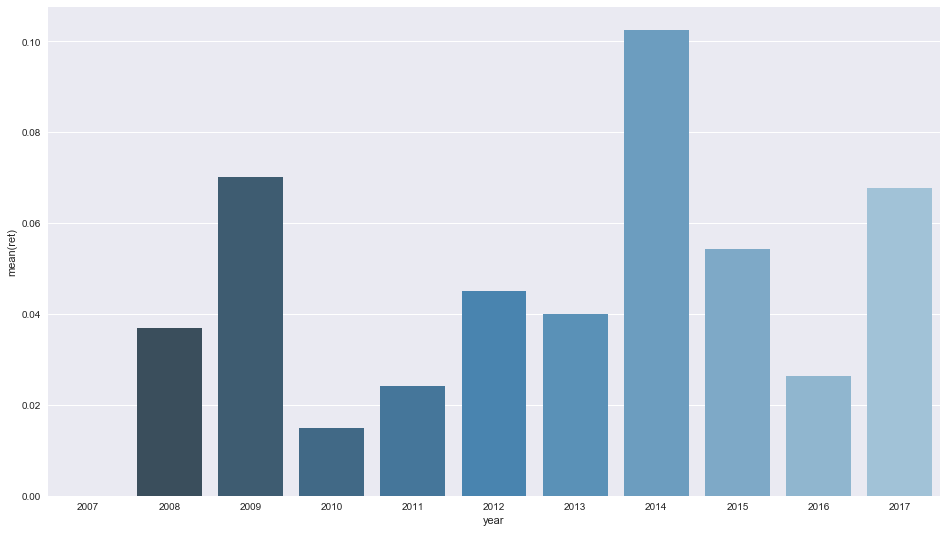

In [112]:
plt.figure(figsize=(16, 9))
sns.barplot(x='year', y='ret', data=bdf, palette="Blues_d")

In [79]:
bdf.to_csv('C:/Users/jgtzsx01/Desktop/rp.csv')

In [113]:
bdf = pd.DataFrame(portfolio_ret4.resample('M').apply(lambda x: pf.empyrical.cum_returns_final(x)))

In [114]:
bdf.columns = ['ret']
bdf['month'] = bdf.index

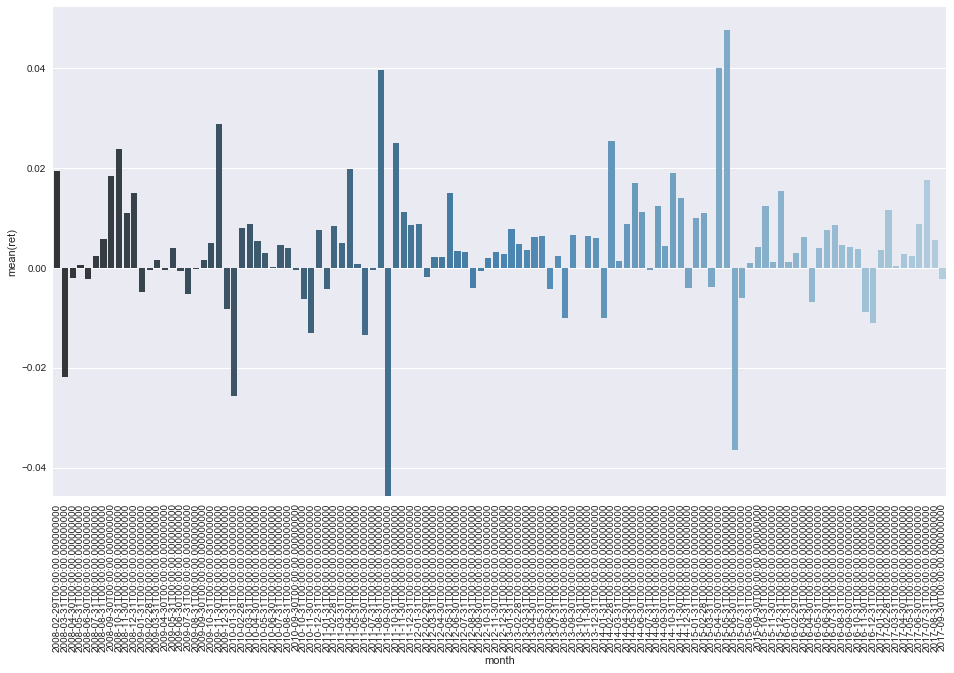

In [115]:
plt.figure(figsize=(16, 9))
plt.xticks(rotation=90)
sns.barplot(x='month', y='ret', data=bdf, palette="Blues_d")